# 1. Import datasets

## 1.1 Import libraries and define paths

In [1]:
import os
import json
import tensorflow as tf

# Define the base directory for augmented datasets
BASE_DATASET_PATH = "data/datasets/augmented"

# Dataset types and dataset sources
DATASET_TYPES = ["train", "test", "val"]
DATASET_SOURCES = ["webcam", "seccam", "seccam_2"]

# Function to generate dataset paths dynamically
def get_dataset_paths(dataset_source, dataset_type):
    base_path = os.path.join(BASE_DATASET_PATH, dataset_source, dataset_type)
    return {
        "images": os.path.join(base_path, "images", "*.jpg"),
        "labels": os.path.join(base_path, "labels", "*.json")
    }

## 1.2 Define image and label loading function

In [3]:
import numpy as np

# Define image sizes for each dataset source
IMAGE_SIZES = {
    "webcam": (480, 640),
    "seccam": (1280, 800),
    "seccam_2": (1280, 800)
}

def load_image_with_size(image_path, source):
    """
    Reads and decodes an image from a given file path and resizes it based on the source.
    
    Args:
        image_path (tf.Tensor): The file path of the image.
        source (str): The dataset source to determine the target size.
    
    Returns:
        tf.Tensor: A decoded, resized, and normalized image tensor.
    """
    image = tf.io.read_file(image_path)  # Read the image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image (ensure 3 color channels)
    target_size = IMAGE_SIZES[source]
    image = tf.image.resize(image, target_size)  # Resize to the target size
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize pixel values to [0,1]
    return image

def load_labels_with_flag(label_path):
    try:
        print(f"Loading label file: {label_path}")
        print(label_path.type)
        # Convert TensorFlow tensor to string if necessary
        if isinstance(label_path, tf.Tensor):
            label_path = label_path.numpy().decode('utf-8')
        with open(label_path, 'r', encoding="utf-8") as f:
            label_data = json.load(f)
        shapes = label_data.get("shapes")
        # Treat None or empty as no label
        if shapes is not None and isinstance(shapes, list) and len(shapes) > 0:
            labels = [int(shape["label"]) for shape in shapes]
            points = np.array([shape["points"] for shape in shapes], dtype=np.float32)
            return labels, points, True  # Valid label
        else:
            # Print a warning for the first few files only
            if hasattr(load_labels_with_flag, "warn_count"):
                if load_labels_with_flag.warn_count < 5:
                    print(f"Warning: No valid shapes in label file: {label_path}")
                    load_labels_with_flag.warn_count += 1
            else:
                load_labels_with_flag.warn_count = 1
                print(f"Warning: No valid shapes in label file: {label_path}")
            return [], np.array([]), False  # No label
    except Exception as e:
        print(f"Error loading label file {label_path}: {e}")
        return [], np.array([]), False

def tf_load_labels(label_path):
    labels, points, valid = tf.py_function(
        load_labels_with_flag, [label_path], [tf.float32, tf.float32, tf.bool]
    )
    return labels, points, valid

## 1.3 Create dataset pielines for labels

In [4]:
def create_datasets_with_size(dataset_source):
    datasets = {}

    for dataset_type in DATASET_TYPES:
        img_size = IMAGE_SIZES[dataset_source]
        paths = get_dataset_paths(dataset_source, dataset_type)

        # Load image dataset
        images = tf.data.Dataset.list_files(paths["images"], shuffle=False)
        images = images.map(lambda x: load_image_with_size(x, dataset_source), num_parallel_calls=tf.data.AUTOTUNE)

        # Load label dataset
        labels = tf.data.Dataset.list_files(paths["labels"], shuffle=False)
        labels = labels.map(tf_load_labels, num_parallel_calls=tf.data.AUTOTUNE)
        # Filter out samples with invalid labels
        labels = labels.filter(lambda labels, points, valid: valid)
        # Remove the validity flag for downstream processing
        labels = labels.map(lambda labels, points, valid: (labels, points), num_parallel_calls=tf.data.AUTOTUNE)

        # Print the number of image and label files for debugging
        num_images = len(tf.io.gfile.glob(paths["images"]))
        num_labels = len(tf.io.gfile.glob(paths["labels"]))
        print(f"[{dataset_source}][{dataset_type}] {num_images} images, {num_labels} labels, image size: {img_size}")
        
        # Zip images and labels
        dataset = tf.data.Dataset.zip((images, labels))
        dataset = dataset.shuffle(5000 if dataset_type == "train" else 1000).batch(8).prefetch(tf.data.AUTOTUNE)

        datasets[dataset_type] = dataset

    return datasets

## 1.4 Prepare and combine datasets from all camera sources
We create TensorFlow datasets for each camera source (webcam, seccam, seccam_2), ensuring images are resized to the correct shape for that source. Then, we combine the training, validation, and test splits from all sources into unified datasets. This ensures the model sees a diverse mix of images from all cameras, improving generalization and robustness.

In [5]:
# Create datasets for each camera source with correct image size
webcam_sets = create_datasets_with_size("webcam")
# seccam_sets = create_datasets_with_size("seccam")
# seccam2_sets = create_datasets_with_size("seccam_2")

# Combine train, val, and test splits from all sources for a unified dataset
combined_train = tf.data.Dataset.sample_from_datasets([
    webcam_sets["train"],
    # seccam_sets["train"],
    # seccam2_sets["train"]
])
combined_val = tf.data.Dataset.sample_from_datasets([
    webcam_sets["val"],
    # seccam_sets["val"],
    # seccam2_sets["val"]
])
combined_test = tf.data.Dataset.sample_from_datasets([
    webcam_sets["test"],
    # seccam_sets["test"],
    # seccam2_sets["test"]
])

# Ensure all batches have consistent shapes for model training
# This function reshapes and validates the structure of images and labels
def reshape_and_ensure_shape(images, labels):
    class_labels, coords = labels
    coords_reshaped = tf.reshape(coords, (tf.shape(coords)[0], 4))

    return (
        tf.ensure_shape(images, [None, None, None, 3]),
        (
            tf.ensure_shape(class_labels, [None, 1]),
            tf.ensure_shape(coords_reshaped, [None, 4])
        )
    )

# Apply the shape correction to the combined datasets
train = combined_train.map(reshape_and_ensure_shape).prefetch(tf.data.AUTOTUNE)
val = combined_val.map(reshape_and_ensure_shape).prefetch(tf.data.AUTOTUNE)
test = combined_test.map(reshape_and_ensure_shape).prefetch(tf.data.AUTOTUNE)

[webcam][train] 1260 images, 1260 labels, image size: (480, 640)
[webcam][test] 300 images, 300 labels, image size: (480, 640)
[webcam][val] 240 images, 240 labels, image size: (480, 640)


## 1.5 Check dataset consistency
Check that the shapes of images and labels in a batch are as expected. This helps catch errors early and ensures the model receives data in the correct format.

In [29]:
# Inspect a sample batch from the training dataset to validate the data pipeline
# This helps ensure images and labels are loaded and shaped correctly before training
found_batch = False
for X_batch, y_batch in train.as_numpy_iterator():
    found_batch = True
    print("Batch contents:")
    print("-" * 50)
    print("Image batch shape:", X_batch.shape)
    print("Class label batch shape:", y_batch[0].shape)
    print("Bounding box batch shape:", y_batch[1].shape)
    # Add some basic validations
    assert len(X_batch.shape) == 4, "Images should be 4D (batch, height, width, channels)"
    assert len(y_batch[0].shape) == 2, "Class labels should be 2D (batch, 1)"
    assert y_batch[1].shape[1] == 4, "Bounding box labels should have 4 coordinates per sample"
    # Print value ranges
    print("\nValue ranges:")
    print("-" * 50)
    print("Image values range:", X_batch.min(), "to", X_batch.max())
    print("Label values:", np.unique(y_batch[0]))
    print("Bounding box values range:", y_batch[1].min(), "to", y_batch[1].max())
    break  # Only inspect the first batch
if not found_batch:
    print("Dataset is empty or iterator exhausted. Please check if the dataset was properly loaded.")

Dataset is empty or iterator exhausted. Please check if the dataset was properly loaded.


In [30]:
# Debug: Print first 3 label file paths and their parsed contents for one dataset
sample_source = DATASET_SOURCES[0]
sample_type = DATASET_TYPES[0]
paths = get_dataset_paths(sample_source, sample_type)
label_files = tf.io.gfile.glob(paths["labels"])
print("Sample label files:", label_files[:3])
for lf in label_files[:3]:
    try:
        with open(lf, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"{lf}: shapes={{}}".format(data.get('shapes')))
    except Exception as e:
        print(f"{lf}: Error {e}")

Sample label files: ['data\\datasets\\augmented\\webcam\\train\\labels\\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.0.json', 'data\\datasets\\augmented\\webcam\\train\\labels\\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.1.json', 'data\\datasets\\augmented\\webcam\\train\\labels\\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.10.json']
data\datasets\augmented\webcam\train\labels\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.0.json: shapes=None
data\datasets\augmented\webcam\train\labels\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.1.json: shapes=None
data\datasets\augmented\webcam\train\labels\f3d9f09a-8335-11ee-9a89-9cfeff47d2fa.10.json: shapes=None


## 1.6 Note on image sizes
This notebook supports datasets with different image sizes. Each source's images are resized to a consistent shape before batching, and the model input shape is set to the largest image size among all sources. This ensures compatibility and robust training across all camera types.

# 2. Build Deep Learning using the Functional API

### 2.1 Import Layers and Base Network

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

### 2.3 Build instance of Network

In [32]:
N = 10  # Number of people to recognize

def build_model(): 
    """
    Builds a face recognition model that outputs embeddings using EfficientNetB0.
    
    Returns:
        Model: Keras model outputting face embeddings.
    """
    
    # Use the largest image size among all sources for the model input
    max_height = max([s[0] for s in IMAGE_SIZES.values()])
    max_width = max([s[1] for s in IMAGE_SIZES.values()])
    input_layer = Input(shape=(max_height, max_width, 3))
    
    # Load EfficientNetB0 as backbone
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

    # Freeze some layers to prevent overfitting and reduce memory usage
    for layer in base_model.layers[:50]:  # Freeze first 50 layers (adjust as needed)
        layer.trainable = False


    # Add embedding head
    x = GlobalAveragePooling2D()(base_model.output)
    # x = Dropout(0.5)(x)  # Add dropout for regularization
    embedding = Dense(128, activation='linear', name='embedding')(x)  # 128-D embedding
    
    return Model(inputs=input_layer, outputs=embedding)

### 2.4 Test out Neural Network

In [33]:
facetracker = build_model()
# facetracker.summary()

In [ ]:
# Convert the iterator's data to numpy arrays for X and y tensors
X, y = train.as_numpy_iterator().next()

# Print shapes to verify the data structure
print("X shape:", X.shape)
print("y shapes:", [y_item.shape for y_item in y])

In [20]:
X.shape

NameError: name 'X' is not defined

In [21]:
classes, coords = facetracker.predict(X)

NameError: name 'X' is not defined

In [16]:
classes, coords

(array([[0.10083655, 0.10683396, 0.11895847, 0.09425458, 0.03959553,
         0.11104301, 0.04580095, 0.13109942, 0.10217203, 0.03010809,
         0.11929733],
        [0.10969134, 0.12449666, 0.0875553 , 0.13560814, 0.0368885 ,
         0.14794968, 0.03578608, 0.12057217, 0.0629259 , 0.03974362,
         0.0987826 ],
        [0.12863298, 0.14649443, 0.07309806, 0.09582441, 0.04662073,
         0.132693  , 0.0382102 , 0.12621866, 0.06205694, 0.04105213,
         0.10909835],
        [0.1160916 , 0.12587877, 0.07893871, 0.10938136, 0.03362691,
         0.14960045, 0.04283874, 0.11910222, 0.07311288, 0.04514894,
         0.10627939],
        [0.10206085, 0.12964305, 0.07280163, 0.09339819, 0.03762029,
         0.12380964, 0.03787843, 0.16418555, 0.06749506, 0.04003795,
         0.13106938],
        [0.09673063, 0.17457093, 0.06996592, 0.11131711, 0.03417847,
         0.1146308 , 0.0468505 , 0.13054074, 0.06856723, 0.02994551,
         0.12270216],
        [0.09977192, 0.10793786, 0.10523

# 3. Define Losses and Optimizers

### 3.1 Define Optimizer and LR

In [37]:
batches_per_epoch = sum(1 for _ in train)
if batches_per_epoch == 0:
    raise ValueError("Training dataset is empty. Cannot compute learning rate decay.")

lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

ValueError: Training dataset is empty. Cannot compute learning rate decay.

### 3.2 Create Localization Loss and Classification Loss

In [18]:
def localization_loss(y_true, yhat):
    # Flatten the ground truth bounding boxes from (batch, 2, 2) to (batch, 4)
    y_true = tf.reshape(y_true, (-1, 4))
    
    # Compute coordinate differences for the top-left corner
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    # Compute height and width for ground truth and prediction
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    # Compute size difference
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [19]:
classloss = tf.keras.losses.sparse_categorical_crossentropy
regressloss = localization_loss

### 3.3 Test out Loss Metrics

In [20]:
# Scale the coordinates to the original image size
coords_scaled = coords * [640, 480, 640, 480]

# Before passing y[1] to localization_loss, reshape it
y_true_reshaped = tf.reshape(y[1], (tf.shape(y[1])[0], 4)) * [640, 480, 640, 480]

# Pass y_true_reshaped instead of y[1] to localization_loss
localization_loss(y_true_reshaped, coords_scaled)

<tf.Tensor: shape=(), dtype=float32, numpy=448555220992.0>

In [21]:
classloss(y[0], classes)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([2.2364793, 2.083476 , 1.9207678, 2.0724359, 2.0429707, 1.7454242,
       2.2261996, 2.2996187], dtype=float32)>

In [22]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1511892.25>

# 4. Train Neural Network

### 4.1 Create Custom Model Class

In [ ]:
BATCH_SIZE = 8

class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, metric_loss_fn, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.optimizer = opt
        self.metric_loss_fn = metric_loss_fn
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = tf.reduce_mean(batch_localizationloss) + 0.5 * tf.reduce_mean(batch_classloss)
            
            gradients = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": tf.reduce_mean(batch_classloss), "regress_loss": tf.reduce_mean(batch_localizationloss)}
    
    # Similarly, update the test_step method
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = tf.reduce_mean(batch_localizationloss) + 0.5 * tf.reduce_mean(batch_classloss)
        
        return {"total_loss": total_loss, "class_loss": tf.reduce_mean(batch_classloss), "regress_loss": tf.reduce_mean(batch_localizationloss)}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [24]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

### 4.2 Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# Ensure GPU usage
with tf.device('/GPU:0'):
    # Train the model with TensorBoard callback
    hist = model.fit(
        train, 
        epochs=10, 
        validation_data=val, 
        callbacks=[tensorboard_callback], 
        verbose=1, 
        batch_size=BATCH_SIZE)

Epoch 1/10


Epoch 1/10


3/3 ━━━━━━━━━━━━━━━━━━━━ 148s 40s/step - class_loss: 0.8006 - regress_loss: 1299513.0000 - total_loss: 1299513.3750 - val_class_loss: 0.0020 - val_regress_loss: 879695.1250 - val_total_loss: 879695.1250
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 148s 40s/step - class_loss: 0.8006 - regress_loss: 1299513.0000 - total_loss: 1299513.3750 - val_class_loss: 0.0020 - val_regress_loss: 879695.1250 - val_total_loss: 879695.1250
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 130s 40s/step - class_loss: 0.0012 - regress_loss: 1304016.0000 - total_loss: 1304016.0000 - val_class_loss: 0.0000e+00 - val_regress_loss: 879695.3750 - val_total_loss: 879695.3750
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 130s 40s/step - class_loss: 0.0012 - regress_loss: 1304016.0000 - total_loss: 1304016.0000 - val_class_loss: 0.0000e+00 - val_regress_loss: 879695.3750 - val_total_loss: 879695.3750
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 127s 40s/step - class_loss: 0.0000e+00 - regress_loss: 1265673.2500 - total_loss: 1265673.2500 - val_class_loss

### 4.3 Plot Performance

In [28]:
hist.history

{'class_loss': [0.11168520152568817,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'regress_loss': [1022124.6875,
  1046408.375,
  893035.625,
  894617.125,
  916209.875,
  990508.6875,
  998107.875,
  945601.25,
  1190869.25,
  955803.4375],
 'total_loss': [1022124.75,
  1046408.375,
  893035.625,
  894617.125,
  916209.875,
  990508.6875,
  998107.875,
  945601.25,
  1190869.25,
  955803.4375],
 'val_class_loss': [0.0020486805588006973,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'val_regress_loss': [879695.125,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375],
 'val_total_loss': [879695.125,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375,
  879695.375]}

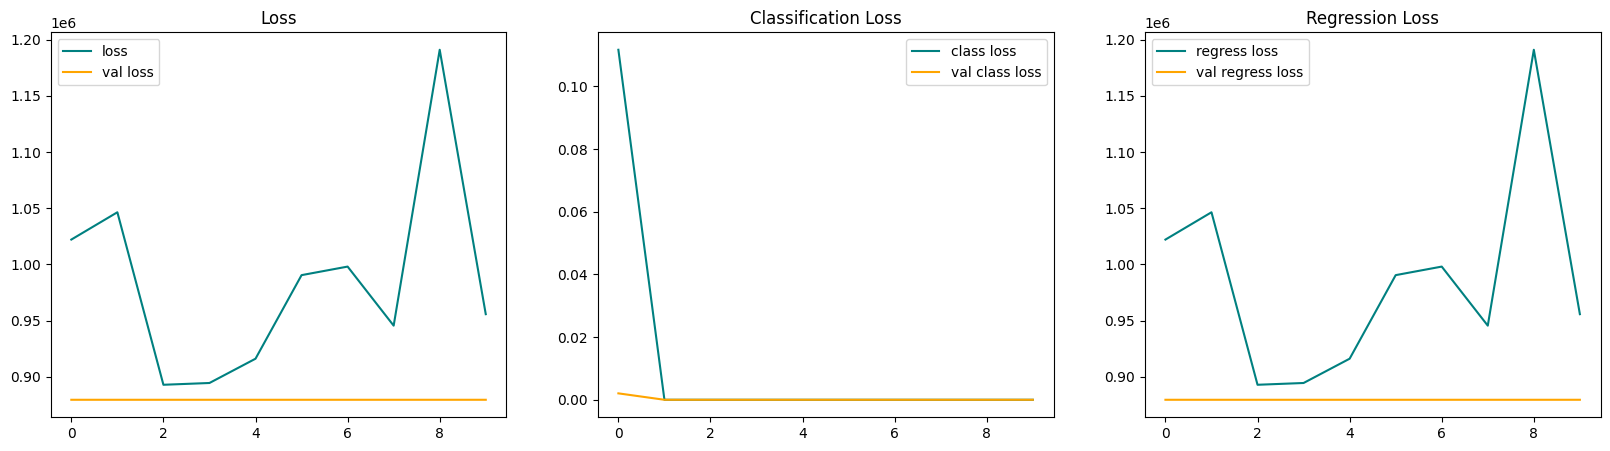

In [29]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 5. Make Predictions

### 5.1 Make Predictions on Test Set

In [30]:
test_data = test.as_numpy_iterator()

In [31]:
test_sample = test_data.next()

In [32]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


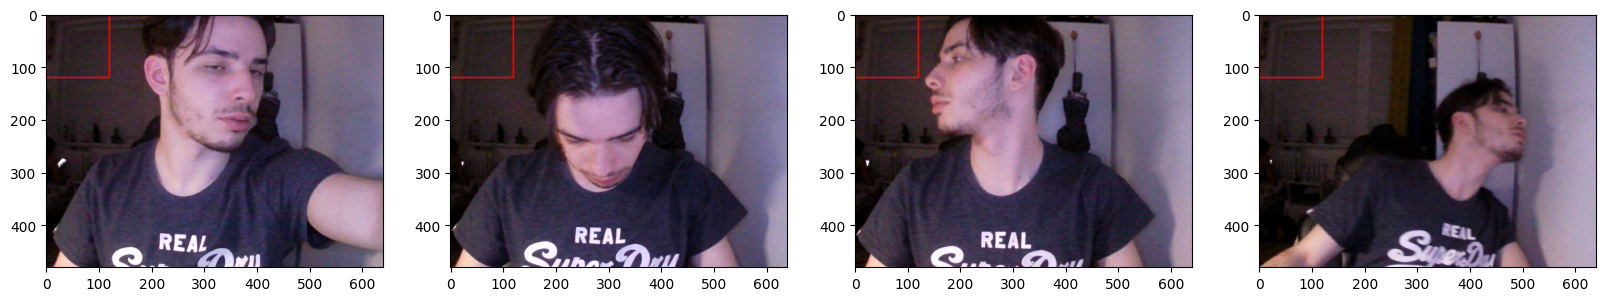

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    # Ensure the sample_image is writable before drawing rectangles
    sample_image = sample_image.copy()

    if np.any(yhat[0][idx] > 0.9):
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# 5.1b Visualize predictions with bounding boxes and class labels
The following cell visualizes predictions by drawing bounding boxes and displaying predicted class labels on sample images from the test set.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Get a batch from the test set
X_vis, y_vis = next(iter(test.as_numpy_iterator()))
classes_pred, coords_pred = facetracker.predict(X_vis)

# When visualizing, use the correct image size for bounding box scaling
def get_image_size_from_shape(img):
    return img.shape[0], img.shape[1]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for idx in range(4):
    img = (X_vis[idx] * 255).astype(np.uint8).copy()
    coords = coords_pred[idx]
    class_id = np.argmax(classes_pred[idx]) if classes_pred.ndim > 1 else int(classes_pred[idx])
    conf = np.max(classes_pred[idx]) if classes_pred.ndim > 1 else float(classes_pred[idx])
    h, w = get_image_size_from_shape(img)
    pt1 = tuple(np.multiply(coords[:2], [w, h]).astype(int))
    pt2 = tuple(np.multiply(coords[2:], [w, h]).astype(int))
    cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
# Put class label and confidence
    label = f"Class: {class_id}, Conf: {conf:.2f}"
    cv2.putText(img, label, (pt1[0], max(pt1[1] - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    axes[idx].imshow(img)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

# 5.1c Plot confusion matrix for classification results
This cell computes and plots a confusion matrix for the predicted vs. true class labels on the test set.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels for a batch
X_cm, y_cm = next(iter(test.as_numpy_iterator()))
classes_pred, _ = facetracker.predict(X_cm)
true_labels = y_cm[0].flatten().astype(int)
pred_labels = np.argmax(classes_pred, axis=1) if classes_pred.ndim > 1 else classes_pred.astype(int)

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Batch)")
plt.show()

### 5.2 Save the Model

In [38]:
import keras

keras.saving.save_model(facetracker, 'custom_model.keras')